In [123]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os


from dynesty import NestedSampler
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

import autolens as al
import autolens.plot as aplt

from plotbin.plot_velfield import plot_velfield
from jampy.mge_radial_mass import mge_radial_mass
from jampy.mge_radial_density import mge_radial_density
from jampy.mge_half_light_isophote import mge_half_light_isophote
from astropy import units as u

In [6]:
phase_name    = "phase5"   # phase to compute the results
result_path   = "./8/model1/{}/".format(phase_name)  #path to the non-linear results
data_path     = "/home/carlos/Documents/GitHub/my_illustris/TNG50-1-snap84-subhalo8" #path to the data
analysis_path = result_path+"Analysis/" #path where the analysis will be saved

os.makedirs(analysis_path)

In [10]:
with open(result_path+'/Final_sampler_{}.pickle'.format(phase_name),'rb') as f:
    sampler = pickle.load(f)
    f.close()

with open(result_path+'/{}.pickle'.format(phase_name),'rb') as f:
    phase = pickle.load(f)
    f.close()

with open(result_path+'/CombinedModel_{}.pickle'.format(phase_name),'rb') as f:
    CM = pickle.load(f)
    f.close()
    
with open(result_path+'/priors_{}.pickle'.format(phase_name),'rb') as f:
    priors = pickle.load(f)
    f.close()

In [13]:
sampler = sampler["sampler"]
print(sampler.results.summary())

Summary
nlive: 500
niter: 3864
ncall: 50100
eff(%):  8.711
logz: 5430.706 +/-  0.134
None


In [14]:
# Generate a new set of results with statistical+sampling uncertainties.
labels = list(priors.keys())
parsRes = priors.copy()
results_sim = dyfunc.jitter_run(dyfunc.resample_run(sampler.results))
samples_sim, weights = results_sim.samples, results_sim.importance_weights()
quantiles = [dyfunc.quantile(samps, [0.16, 0.5,  0.84], weights=weights)
            for samps in samples_sim.T]                        #quantiles for each parameter

    #Update the parameters
for i, key in enumerate(parsRes.keys()):
    parsRes[key] = quantiles[i][1]
    print(key, parsRes[key])


inc 82.24776188129624
beta -0.016945492021890305
ml 2.354315000716506
log_rho_s -2.2094455937194137
rs 14.924591999764981
slope 0.8272182591346277


In [15]:
fig, axes = dyplot.traceplot(results=results_sim, show_titles=True,
                             labels=labels,
                             )
fig.tight_layout()
plt.savefig(analysis_path+"/tracer_plot.png")
plt.close()

In [16]:
# Plot the 2-D marginalized posteriors.
cfig, caxes, = dyplot.cornerplot(results_sim, smooth=0.08,
                                show_titles=True,labels=labels,
                         )
fig.tight_layout()
plt.savefig(analysis_path+"/corner_plot.png")
plt.close()

In [20]:
if phase_name == "phase1":
    source_ell_comp = al.convert.elliptical_comps_from(axis_ratio=parsRes["source_q"], 
                                                       angle=parsRes["source_phi"])

    source_model = al.Galaxy(
        redshift=CM.Lens_model.z_s,
        light=al.lp.EllSersic(
            centre=(parsRes["source_y0"], parsRes["source_x0"]),
            elliptical_comps=source_ell_comp,
            intensity=parsRes["source_intensity"],
            effective_radius=parsRes["source_eff_r"],
            sersic_index=parsRes["source_n_index"],
        ),
    )    


    CM.source_galaxy(source_model)

else:
    
    adp_pix = phase.source_pix(pixels=int(phase.parsSource["pixels"]),
                                weight_floor=phase.parsSource["weight_floor"],
                                weight_power=phase.parsSource["weight_power"]
                                )

    adp_reg = phase.source_reg(inner_coefficient=phase.parsSource["inner_coefficient"],
                                outer_coefficient=phase.parsSource["outer_coefficient"],
                                signal_scale=phase.parsSource["signal_scale"]
                                )

    source_model = al.Galaxy(redshift=CM.Lens_model.z_s,
                                pixelization=adp_pix, regularization=adp_reg,
                                hyper_model_image=phase.hyper_image_2d,
                                hyper_galaxy_image=phase.hyper_image_2d,
                                )

    CM.source_galaxy(source_model=source_model)  #Setting the source galaxy model
CM.quiet = False
CM.Updt_Model(parsRes)



 --------------------------------- 

ParsDic: {'inc': 82.24776188129624, 'beta': -0.016945492021890305, 'ml': 2.354315000716506, 'log_rho_s': -2.2094455937194137, 'rs': 14.924591999764981, 'qDM': 1.0, 'slope': 0.8272182591346277, 'gamma': 1.0}

 --------------------------------- 

Parameters Updated!


jam_axi_rms elapsed time sec: 0.06
No PSF convolution: sigmapsf == 0;
inc=82.2 beta_z=-0.02 M/L=1.00 BH=0.00e+00 chi2/DOF=1.33
Total mass MGE: 5.587e+13
Including the following Analytical DM profile:
#------------------------------------#
EllNFWGeneralized
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.0)
kappa_s: 0.0922603684907089
scale_radius: 14.924591999764981
inner_slope: 0.8272182591346277


Lens Galaxy Configuration:
Log Likelihood_with_regularization: 5930.377668345433
Log Likelihood: 5939.093625575467
Log Normalization -14428.520733928935
Log Evidence: 5491.034776004921
Figure of merit: 5491.034776004921
#------------------------------------#
Redshift: 0.1972841823760099
Mass Profiles:
MGE
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.0)
gamma: 1.0
cosmology: FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)
analytic_profile: EllNFWGeneralized
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.0)
kappa_s: 0.

<Figure size 1800x1000 with 0 Axes>

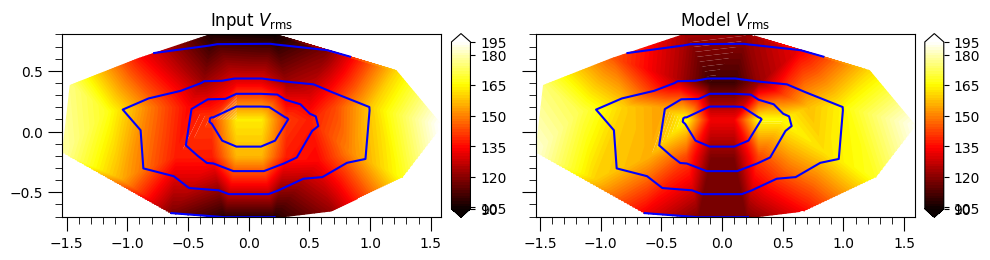

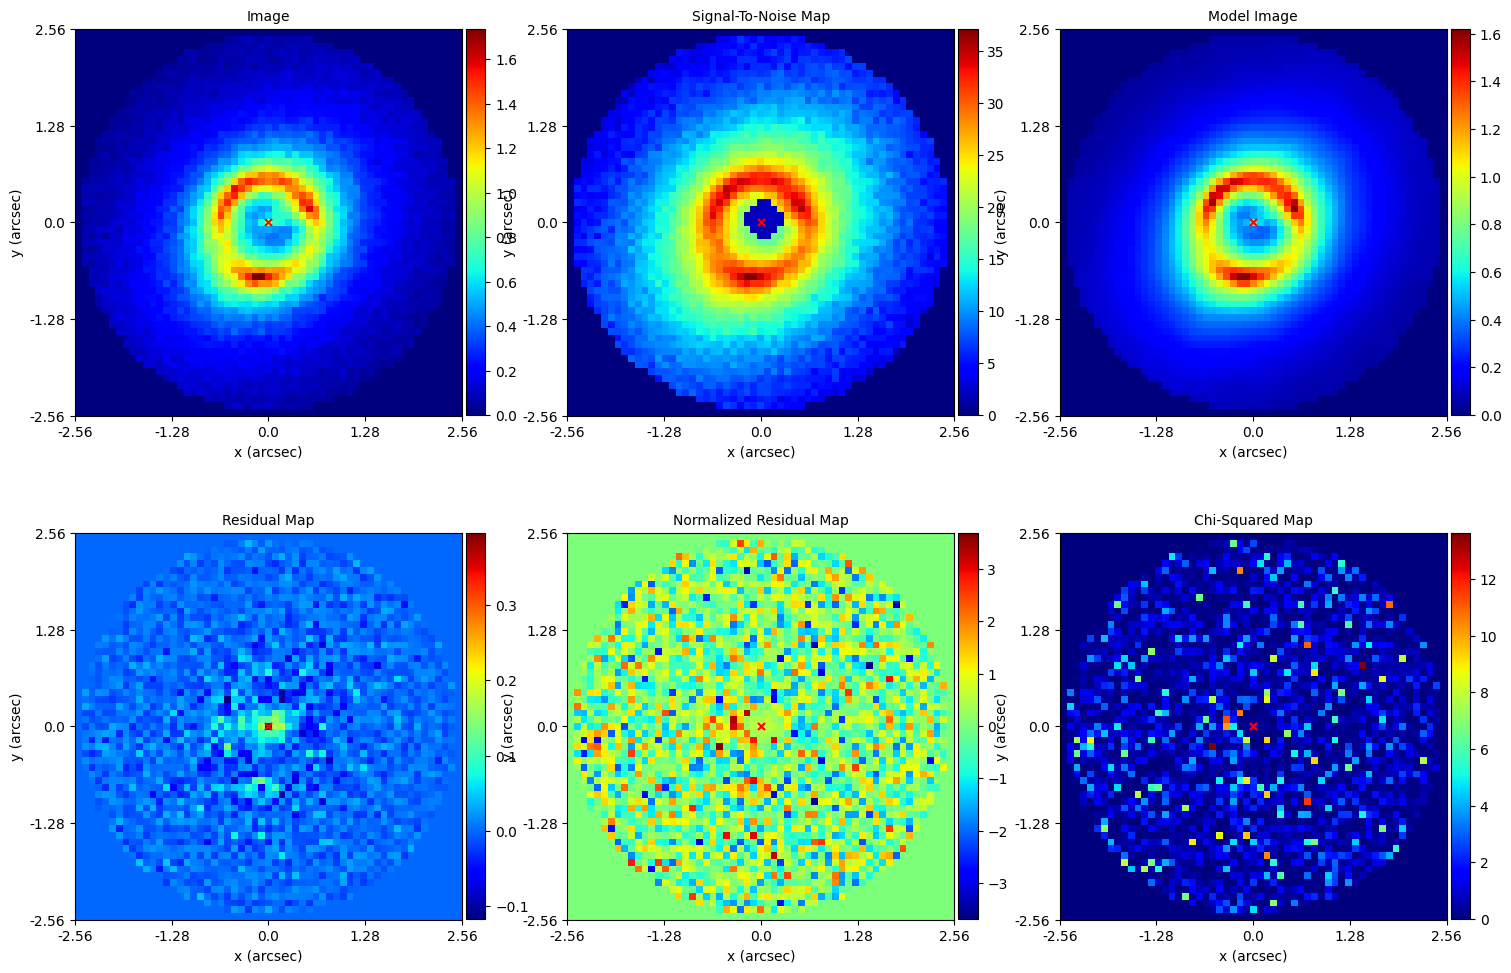

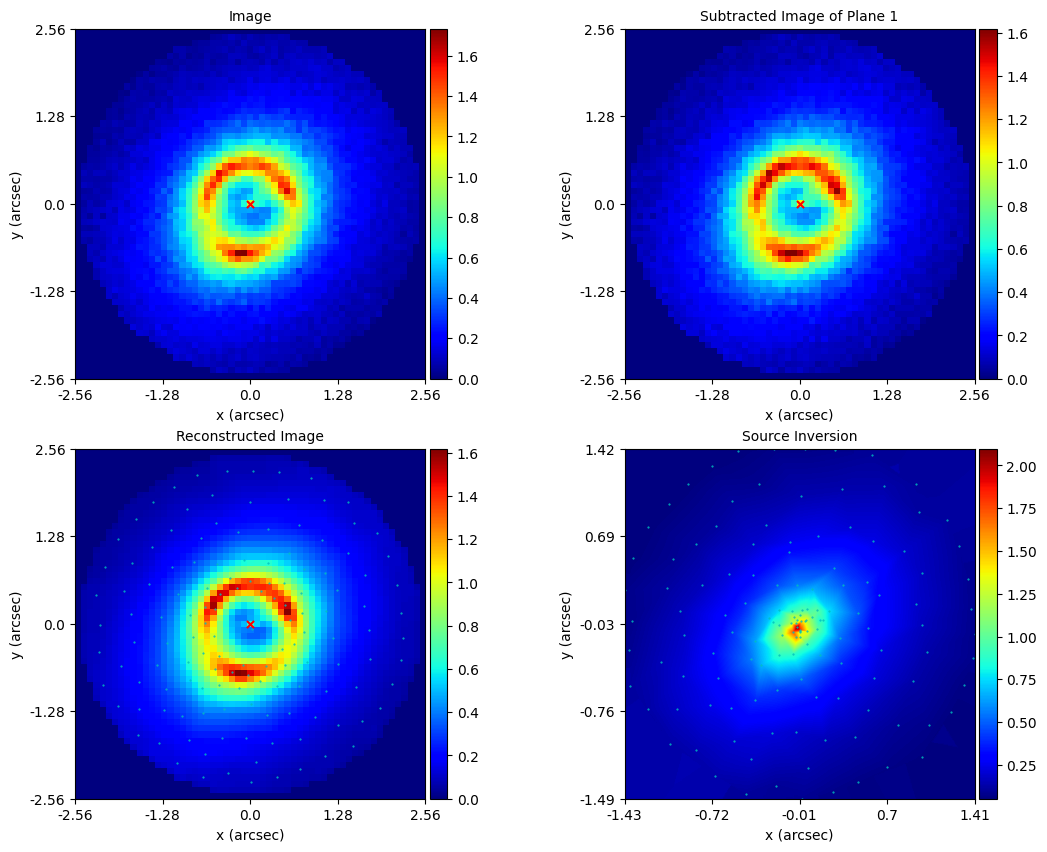

In [21]:
plt.figure(figsize=(18,10))
CM.run_current(quiet=False)
plt.tight_layout()
plt.savefig(analysis_path+"/model.png")
plt.close()

In [96]:
cmap = aplt.Cmap(
    cmap="rainbow"
)

mat_plot_2d_output = aplt.MatPlot2D(
    output=aplt.Output(
        filename=f"None",
        path=analysis_path,
        format=["png",],
        format_folder=True,
    ),
    cmap=cmap
)
mat_plot_2d =  mat_plot_2d_output


In [97]:
fit_plotter = aplt.FitImagingPlotter(fit=CM.Fit, mat_plot_2d=mat_plot_2d)
mat_plot_2d.output.filename = "fit_subplot"
fit_plotter.subplot_fit_imaging()

In [98]:
mat_plot_2d.output.filename = "fit_image"
fit_plotter.figures_2d(image=True)

In [99]:
mat_plot_2d.output.filename = "fit_model"
fit_plotter.figures_2d(model_image=True)

In [100]:
mat_plot_2d.output.filename = "residual"
fit_plotter.figures_2d(residual_map=True)

In [101]:
mat_plot_2d.output.filename = "subplot_plane"
fit_plotter.subplot_of_planes(plane_index=1)

In [102]:
inversion_plotter = aplt.InversionPlotter(inversion=CM.Fit.inversion, mat_plot_2d=mat_plot_2d)

In [103]:
mat_plot_2d.output.filename = "reconstruction"

inversion_plotter.figures_2d_of_mapper(
    mapper_index=0,
    reconstruction=True)

In [104]:
mat_plot_2d.output.filename = "subplot_inversion"
inversion_plotter.subplot_of_mapper(mapper_index=0)

In [113]:
fig = plt.figure(figsize=(18, 10))
rmsModel, ml, chi2, chi2T = CM.Jampy_model._run(plot=True, cmap="rainbow", label=r"km/s", xlabel="arcsec")

plt.tight_layout()
plt.savefig(analysis_path+"/jam_model.png")
plt.close()

In [110]:
fig = plt.figure(figsize=(18, 10))
plot_velfield(CM.Jampy_model.xbin, CM.Jampy_model.ybin, 
            100*abs(CM.Jampy_model.rms-rmsModel)/CM.Jampy_model.rms,
            colorbar=True,  cmap="rainbow",  
            markersize=0.2, label="[%]")
plt.title(r"${\Delta V_{\rm rms}^{*}}$")

fig.tight_layout()
plt.savefig(analysis_path+"/jam_residual.png")
plt.close()

In [114]:
import json
 # the json file where the output must be stored
out_descripition = open("{}/description.json".format(analysis_path), "w")
description = { "Reff":  "MGE effetive radius, in arcsec.",
                "thetaE": "Measured Einstein Ring in arcsec",
                "R":     "Radius where quantities were measured, in arcsec.",
                "Mstar": "True stellar mass within R, in 1e10Msun.", 
                "Mdm":   "True dm mass within R, in 1e10Msun.", 
                "Mbh":   "True BH mass within R, in 1e10Msun.", 
                "Mtotal":"True total mass within R, in 1e10Msun.", 
                "fdm":   "Fraction of DM within R.",
                "MMstar": "Model stellar mass within R, in 1e10Msun.", 
                "MMdm":   "Model dm mass within R, in 1e10Msun.", 
                "MMbh":   "Model BH mass within R, in 1e10Msun.", 
                "MMtotal":"Model total mass within R, in 1e10Msun.", 
                "Mfdm":   "Model DM fraction within R.",
                "Dstar":  "(MMstar - Mstar)/Mstar",
                "Ddm":    "(MMdm - Mdm)/Mdm",
                "Dtotal": "(MMtotal - Mtotal)/Mtotal",
                "Dfdm":   "(Mfdm - fdm)/fdm"
               }
json.dump(description, out_descripition, indent = 8)
out_descripition.close()

In [115]:
einstein_radius = CM.Fit.tracer.einstein_radius_from(CM.Fit.imaging.grid)
einstein_radius

Grid2DIrregular(0.63523841)

In [116]:
# Get the effective radius in arcsec, and other quantities
# See mge_half_light_isophote documentation for more details
reff, reff_maj, eps_e, lum_tot = mge_half_light_isophote(CM.Lens_model.surf_lum,
                                                         CM.Lens_model.sigma_lum,
                                                         CM.Lens_model.qobs_lum,
                                                         CM.Jampy_model.distance)

In [118]:
#  Model
R     = 2.5*reff    # 2.5 Reff in arcsec
R_kpc = ( (R*u.arcsec * CM.Jampy_model.distance*u.Mpc ).to(
                    u.kpc,u.dimensionless_angles()) ).value # 2.5Reff in kpc


    # Get the radial mass of stars and DM within rad
MMstar = float ( mge_radial_mass(CM.Jampy_model.surf_lum * CM.Jampy_model.ml_model, 
                               CM.Jampy_model.sigma_lum, CM.Jampy_model.qobs_lum,
                               CM.Jampy_model.inc, R, CM.Jampy_model.distance) )

MMdm = float ( mge_radial_mass(CM.Jampy_model.surf_dm, 
                               CM.Jampy_model.sigma_dm, CM.Jampy_model.qobs_dm,
                               CM.Jampy_model.inc, R, CM.Jampy_model.distance) )
MMbh = float ( CM.Jampy_model.mbh )  # Model BH mass

    # Total Mass
MMtotal = MMstar + MMdm
    # Dark matter fraction
Mfdm = MMdm / MMtotal

In [119]:
# Data quantities

# Load the snapshot data
dm_dataset   = np.load(data_path+"/dm/coordinates_dark.npy")
star_dataset = np.load(data_path+"/imgs/coordinates_star.npy")

    # Stellar content
rStar = np.sqrt(np.sum(star_dataset[:, 0:3]**2, axis=1)) # radius
i = rStar <= R_kpc                                       # only particles within R
Mstar = sum(star_dataset[:, 6][i]*1e10)                  # mass within   R

    # Dark content
rDM = np.sqrt(np.sum(dm_dataset[:, 0:3]**2, axis=1))
i = rDM <= R_kpc
Mdm = sum(dm_dataset[:,3][i]*1e10)

Mbh = 1e8 # should be the BH mass from TNG catalogue 
Mtotal = Mstar + Mdm         # Total snapshot mass within R
fdm = Mdm/Mtotal             # DM fraction in the snapshot within R

In [120]:
print('=' * term_size.columns)
    # Accuracy in stellar mass
print("Model stellar Mass: {:.2e} Msun".format( float(MMstar) ))
print("Data  stellar Mass: {:.2e} Msun".format( float(Mstar) ))
Dstar = float ( (MMstar - Mstar)/Mstar )
print("(Model - Data)/Data: {:.2f}".format( float(Dstar) ))
print('=' * term_size.columns)
    # Accuracy in Dm mass
print("Model dm Mass: {:.2e} Msun".format( float(MMdm) ))
print("Data  dm Mass: {:.2e} Msun".format( float(Mdm) ))
Ddm = float ( (MMdm - Mdm)/Mdm )
print("(Model - Data)/Data: {:.2f}".format( float(Ddm) ))
print('=' * term_size.columns)
    # Accuracy in total mass
print("Model total Mass: {:.2e} Msun".format( float(MMtotal) ))
print("Data  total Mass: {:.2e} Msun".format( float(Mtotal) ))
Dtotal = float ( (MMtotal - Mtotal)/Mtotal )
print("(Model - Data)/Data: {:.2f}".format( float(Dtotal) ))
print('=' * term_size.columns)
    # Accuracy in dm fraction
print("Model DM fraction: {:.2f}".format( float(Mfdm) ))
print("Data  DM fraction: {:.2f}".format( float(fdm) ))
Dfdm = float ( (Mfdm - fdm)/fdm )
print("(Model - Data)/Data: {:.2f}".format( float(Dfdm) ))

NameError: name 'term_size' is not defined

In [124]:
# Radial density profiles
radii    = np.arange(0.1, 10*reff, 0.01)   # Radii in arcsec
pc       = CM.Jampy_model.distance*np.pi/0.648  # Constant factor to convert arcsec --> pc
radii_pc = radii*pc                        # Radii in pc

dstar = mge_radial_density(CM.Jampy_model.surf_lum * CM.Jampy_model.ml_model, 
                            CM.Jampy_model.sigma_lum, CM.Jampy_model.qobs_lum,
                            CM.Jampy_model.inc, radii, CM.Jampy_model.distance)

ddm = mge_radial_density(CM.Jampy_model.surf_dm, 
                            CM.Jampy_model.sigma_dm, CM.Jampy_model.qobs_dm,
                            CM.Jampy_model.inc, radii, CM.Jampy_model.distance)

# Load DM density profile
from astropy.io import fits
dm_hdu = fits.open(data_path+"/dm/density_fit.fits")
true_density = dm_hdu[1].data["density"]
true_radii = dm_hdu[1].data["radius"]
dm_fit = dm_hdu[1].data["bestfit"]

i = true_radii < radii_pc.max()

true_density = true_density[i]
true_radii   = true_radii[i]
dm_fit = dm_fit[i]

# Load star density profile
star_hdu = fits.open(data_path+"/imgs/stellar_density.fits")
rho_stars = star_hdu[1].data["density"]
r_star = star_hdu[1].data["radius"]


i = r_star < radii_pc.max()

rho_stars = rho_stars[i]
r_star   = r_star[i]

plt.rcParams['xtick.labelsize']= 12
plt.rcParams['ytick.labelsize']= 12


plt.figure(figsize=(15,8))

plt.plot(radii_pc, np.log10(dstar), label="Star", color="red")
plt.plot(radii_pc, np.log10(ddm), label="DM", color="magenta")
plt.plot(radii_pc, np.log10(ddm+dstar), label="Total", color="black")
plt.plot(true_radii, np.log10(dm_fit), label="DM Fit", color="blue", markersize=12)
#plt.plot(radii_pc, np.log10(a), label="MGE", color="black")

plt.plot(true_radii, np.log10(true_density),  ".", label="DM data", color="magenta", markersize=12)

plt.plot(r_star, np.log10(rho_stars),  ".", label="Stars data", color="red", markersize=12)
plt.plot(r_star, np.log10(rho_stars+true_density),  ".", label="Total data", color="black", markersize=12)




plt.xlabel("radii [pc]", size=20)
plt.ylabel("$\log_{10}(\\frac{\\rho}{M_\odot/pc^3})$", size=20)
plt.legend()
plt.xscale("log")
plt.tight_layout()
plt.savefig(analysis_path+"/density_profiles.png")
plt.close()


# Save quantities
r = {}
r["Reff"]   = reff
r["R"]      = R
r["thetaE"] = einstein_radius
r["Mstar"]  = float( np.log10(Mstar) )
r["Mdm"]    = float( np.log10(Mdm)   )
r["Mbh"]    = float( np.log10(Mbh)   )
r["Mtotal"] = float( np.log10(Mtotal) )
r["fdm"]    = fdm
r["MMstar"]  = float( np.log10(MMstar) )
r["MMdm"]    = float( np.log10(MMdm)   )
r["MMbh"]    = float( np.log10(MMbh)   )
r["MMtotal"] = float( np.log10(MMtotal) )
r["Mfdm"]    = float( Mfdm )
r["Dstar"]   = Dstar
r["Ddm"]     = Ddm
r["Dtotal"]  = Dtotal
r["Dfdm"]    = Dfdm
# the json file where the output must be stored
out_r = open("{}/quantities.json".format(analysis_path), "w")
json.dump(r, out_r, indent = 8)
out_r.close()

NameError: name 'Dstar' is not defined

In [128]:
float(einstein_radius)

0.6352384086739297